In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ~/semantic_uncertainty/semantic_uncertainty

/home/cutter/semantic_uncertainty/semantic_uncertainty


In [4]:
import numpy as np
import random
import itertools
import umap
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import wandb

from uncertainty.data.data_utils import load_ds
from uncertainty.utils import utils
from compute_uncertainty_measures import main as main_compute

from analyze_results import analyze_run
from uncertainty.uncertainty_measures.p_ik import get_p_ik
from uncertainty.uncertainty_measures.semantic_entropy import get_semantic_ids
from uncertainty.uncertainty_measures.semantic_entropy import logsumexp_by_id
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy_rao
from uncertainty.uncertainty_measures.semantic_entropy import cluster_assignment_entropy
from uncertainty.uncertainty_measures.semantic_entropy import context_entails_response
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentDeberta
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT35
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4Turbo
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentLlama

In [5]:
parser = utils.get_parser()
args, unknown = parser.parse_known_args()

In [17]:
args.num_generations = 10
args.use_context = False

In [18]:
experiment_details = {'args': args}
random.seed(args.random_seed)

In [19]:
# Get accuracy metric.
metric = utils.get_metric(args.metric)

# Load dataset.
train_dataset, validation_dataset = load_ds(
    args.dataset, add_options=args.use_mc_options, seed=args.random_seed)

In [20]:
# Get indices of answerable and unanswerable questions and construct prompt.
answerable_indices, unanswerable_indices = utils.split_dataset(train_dataset)

if args.answerable_only:
    unanswerable_indices = []
    val_answerable, val_unanswerable = utils.split_dataset(validation_dataset)
    del val_unanswerable
    validation_dataset = [validation_dataset[i] for i in val_answerable]

prompt_indices = random.sample(answerable_indices, args.num_few_shot)
experiment_details['prompt_indices'] = prompt_indices
remaining_answerable = list(set(answerable_indices) - set(prompt_indices))

In [21]:
# Create Few-Shot prompt.
make_prompt = utils.get_make_prompt(args)
BRIEF = utils.BRIEF_PROMPTS[args.brief_prompt]
arg = args.brief_always if args.enable_brief else True
prompt = utils.construct_fewshot_prompt_from_indices(
    train_dataset, prompt_indices, BRIEF, arg, make_prompt)
experiment_details['prompt'] = prompt
experiment_details['BRIEF'] = BRIEF

In [ ]:
# Initialize model.
model = utils.init_model(args)

In [ ]:
entailment_model = EntailmentDeberta()

In [12]:
# Grab example.
dataset = train_dataset
example = dataset[6]
question, context = example["question"], example['context']
generations = {'question': question, 'context': context}
correct_answer = example['answers']['text']

current_input = make_prompt(
context, question, None, BRIEF, args.brief_always and args.enable_brief)
local_prompt = prompt + current_input

In [13]:
full_responses = []

# We sample one low temperature answer on which we will compute the
# accuracy and args.num_generation high temperature answers which will
# be used to estimate the entropy variants.

num_generations = args.num_generations + 1

for i in range(num_generations):

    # Temperature for first generation is always `0.1`.
    temperature = 0.1 if i == 0 else args.temperature

    predicted_answer, token_log_likelihoods, embedding = model.predict(
        local_prompt, temperature)
    embedding = embedding.cpu() if embedding is not None else None

    # Only compute accuracy if question is answerable.
    compute_acc = args.compute_accuracy_at_all_temps or (i == 0)
    if correct_answer and compute_acc:
        acc = metric(predicted_answer, example, model)
    else:
        acc = 0.0  # pylint: disable=invalid-name

    if i == 0:
        print('question: '.ljust(15) + question)
        # if args.use_context:
        print('context: '.ljust(15) + str(context))
        print('low-t prediction: '.ljust(15) + predicted_answer)
        print('correct answer: '.ljust(15) + str(correct_answer))
        print('accuracy: '.ljust(15) + str(acc))

        most_likely_answer_dict = {
            'response': predicted_answer,
            'token_log_likelihoods': token_log_likelihoods,
            'embedding': embedding,
            'accuracy': acc}
        generations.update({
            'most_likely_answer': most_likely_answer_dict,
            'reference': utils.get_reference(example)})

    else:
        print('high-t prediction '.ljust(15) + str(i) + ' : ' + predicted_answer)
        # Aggregate predictions over num_generations.
        full_responses.append(
            (predicted_answer, token_log_likelihoods, embedding, acc))

# Append all predictions for this example to `generations`.
generations['responses'] = full_responses

question:      "Who painted ""Boy With a Pipe"" which, in May 2004, was sold for a record price of $104 million?"
context:       [DOC] [TLE] Worldandnation: Picasso sells for record - Tampa Bay TimesSt. Petersburg Times Online:  World and National news [PAR] By Associated Press [PAR] Published May 6, 2004 [PAR] NEW YORK - Pablo Picasso's 1905 painting Boy with a Pipe sold for $104-million Wednesday at Sotheby's, shattering the record for an auctioned painting. [PAR] The total includes the auction price of $93-million plus the auction house's commission of about $11-million. [PAR] The previous record was set by Vincent van Gogh's 1890 Portrait of Doctor Gachet, which was sold to a Japanese billionaire for $82.5-million in 1990 at Christie's, including the auction house's premium. [PAR] Sotheby's did not immediately say who bought Boy with a Pipe. [PAR] A 24-year-old Picasso painted Boy with a Pipe soon after settling in Montmartre, France. [PAR] The painting was part of a collection of 

In [14]:
# Compute semantic ids.
responses = [r[0] for r in full_responses]
log_liks = [r[1] for r in full_responses]
semantic_ids = get_semantic_ids(
    responses, model=entailment_model,
    strict_entailment=args.strict_entailment, example=example)

In [15]:
semantic_classes = {}
for i, response in enumerate(full_responses):
    if semantic_ids[i] not in semantic_classes:
        semantic_classes[semantic_ids[i]] = [response]
    else:
        semantic_classes[semantic_ids[i]].append(response)

In [16]:
entropies = defaultdict(list)

# Compute entropy from frequencies of cluster assignments.
entropies['cluster_assignment_entropy'].append(cluster_assignment_entropy(semantic_ids))

# Length normalization of generation probabilities.
log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]

# Compute naive entropy.
entropies['regular_entropy'].append(predictive_entropy(log_liks_agg))

# Compute semantic entropy.
log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_liks_agg, agg='sum_normalized')
pe = predictive_entropy_rao(log_likelihood_per_semantic_id)
entropies['semantic_entropy'].append(pe)

## UMAP Visualization of Embeddings for each Semantic Class

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm

In [18]:
embeddings = [r[2] for r in full_responses]
embeddings = torch.stack(embeddings)
embeddings = embeddings.squeeze()

In [19]:
# Fit UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=3)
X_umap = reducer.fit_transform(embeddings)

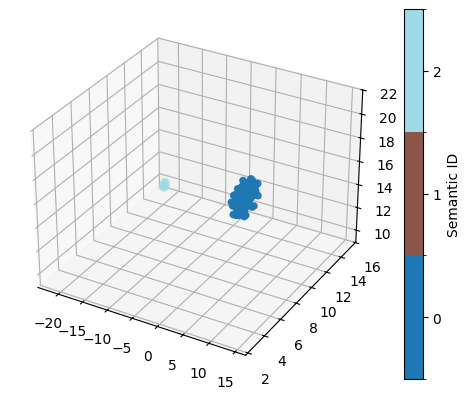

In [20]:
# Plot
fig = plt.figure()

cmap = plt.get_cmap('tab20', len(np.unique(semantic_ids))) 
norm = BoundaryNorm(np.arange(-0.5, len(np.unique(semantic_ids)) + 0.5), cmap.N)

ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=semantic_ids, cmap=cmap, norm=norm)

cbar = fig.colorbar(sc, ax=ax, ticks=np.unique(semantic_ids))  # Set colorbar labels to semantic IDs)))
cbar.ax.set_yticklabels(np.unique(semantic_ids))  # Set colorbar labels to semantic IDs
cbar.set_label('Semantic ID')

plt.show()

In [20]:
similarities = []

for i, response_i in enumerate(generations['responses']):
    embedding_i = response_i[2]
    semantic_id_i = semantic_ids[i]
    for j, response_j in enumerate(generations['responses']):
        if i >= j:
            continue
        embedding_j = response_j[2]
        semantic_id_j = semantic_ids[j]

## Experimenting with Context Probabilities

In [22]:
# Grab example.
dataset = train_dataset
example = dataset[6]
question, context = example["question"], example['context']
generations = {'question': question, 'context': context}
correct_answer = example['answers']['text']

current_input = make_prompt(
context, question, None, BRIEF, args.brief_always and args.enable_brief)
local_prompt = prompt + current_input

In [ ]:
question_context = 'Question: '

'"Who painted ""Boy With a Pipe"" which, in May 2004, was sold for a record price of $104 million?"'